# Structure Learning in Bayesian Networks

A Bayesian Network (BN) is a graphical representation of the probabilistic relationships among a set of variables. The challenge of structure learning in Bayesian networks is to find the best network structure (directed acyclic graph) that explains the observed data.

In the Bayesian approach, we treat the network structure as a random variable and compute the posterior distribution of structures given the observed data. The most probable structure given the data is then selected as the best structure. Mathematically:

$$P(G | D) = \frac{P(D | G) P(G)}{P(D)}$$

Where:
- $P(G | D)$ is the posterior probability of structure $G$ given data $D$.
- $P(D | G)$ is the likelihood of data \left( D \right) given structure $G$ (this is the marginal likelihood we're interested in).
- $P(G)$ is the prior probability of structure \left( G \right).
- $P(D)$ is the probability of the data, also known as the marginal likelihood of the data, which acts as a normalizing constant.

The objective is to maximize $P(G | D)$, which is equivalent to maximizing $P(D | G) P(G)$, since $P(D)$ is constant for all structures.

## Marginal Likelihood

To compute $P(D | G)$, we need to integrate over all possible parameter values:

$$P(D | G) = \int P(D | \theta, G) P(\theta | G) d\theta$$

Where:
- $\theta$ represents the parameters of the Bayesian network (e.g., conditional probabilities in discrete BNs or regression coefficients in Gaussian BNs).
- $P(D | \theta, G)$ is the likelihood of the data given the parameters and the structure.
- $P(\theta | G)$ is the prior distribution of the parameters given the structure.

## The Case of Gaussian Bayesian Networks

We define a Gaussian Bayesian network to be a Bayesian network all of whose variables are continuous, and where all of the CPDs are linear Gaussians.



### Marginal Likelihood

Consider a single node $Y$ in a Gaussian Bayesian network with parents $\textbf{Pa}(Y)$. Given the Gaussian Bayesian network assumptions:

- $Y$ is linearly dependent on its parents $\textbf{Pa}(Y)$ with some Gaussian noise.
- The relationship is given by:


$$Y = \boldsymbol{\beta}^T \textbf{Pa}(Y) + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)$$

Where:
- $\boldsymbol{\beta}$ is a vector of regression coefficients.
- $\sigma^2$ is the variance of the error term $\epsilon$.

### Priors:

For Bayesian inference, we need priors on our parameters:

1. $\boldsymbol{\beta}$ has a multivariate normal prior:

$$\boldsymbol{\beta} \sim \mathcal{N}(\mathbf{0}, \sigma^2 \boldsymbol{\Lambda}_0^{-1})$$

Here, $\boldsymbol{\Lambda}_0$ is the prior precision matrix (inverse of the covariance matrix) for $\boldsymbol{\beta}$.

2. $\sigma^2$ has an inverse gamma prior:

$$\sigma^2 \sim \text{Inv-Gamma}(a_0, b_0)$$

Where $a_0$ and $b_0$ are the shape and scale parameters, respectively.

### Computing the Marginal Likelihood:

The marginal likelihood is obtained by integrating out the parameters $\beta$ and $\sigma$:

$$P(Y | \textbf{Pa}(Y), G) = \int \int P(Y | \boldsymbol{\beta}, \sigma^2, \textbf{Pa}(Y), G) P(\boldsymbol{\beta} | \sigma^2, G) P(\sigma^2 | G) \, d\boldsymbol{\beta} \, d\sigma^2$$

Given our assumptions, this integral simplifies considerably:

- The likelihood $P(Y | \boldsymbol{\beta}, \sigma^2, \textbf{Pa}(Y), G)$ is a normal distribution.
- The prior $P(\boldsymbol{\beta} | \sigma^2, G)$ is also a normal distribution.
- The prior $P(\sigma^2 | G)$ is an inverse gamma distribution.

The product of two normal distributions is another normal distribution. The product of a normal and an inverse gamma distribution is a multivariate Student's t-distribution.

Given this, the integral can be solved analytically, leading to the formula:

$$
P(\mathbf{Y} | G) = \frac{1}{(2\pi)^{n/2}} \sqrt{\frac{\det(\boldsymbol{\Lambda}_0)}{\det(\boldsymbol{\Lambda}_n)}} \cdot \frac{b_0^{a_0}}{b_n^{a_n}} \cdot \frac{\Gamma(a_n)}{\Gamma(a_0)}
$$

Where:
- $ \boldsymbol{\Lambda}_n$ is the updated precision matrix after observing the data.
- $a_n$ and $b_n$ are the updated parameters of the inverse gamma distribution after observing the data.

Taking the natural logarithm of both sides, we get the log marginal likelihood:

$$\log(p(\mathbf{Y} | G)) = -\frac{n}{2} \log(2\pi) + \frac{1}{2} \left( \log\det(\boldsymbol{\Lambda}_0) - \log\det(\boldsymbol{\Lambda}_n) \right) + a_0 \log(b_0) - a_n \log(b_n) + \log\Gamma(a_n) - \log\Gamma(a_0)$$



## Score Functions

In [28]:
import pandas as pd
import numpy as np
import networkx as nx
import arviz as az

import matplotlib.pyplot as plt

from scipy.stats import norm
from sklearn.linear_model import LinearRegression

import itertools
import random

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from scipy.special import gamma
from scipy.special import gammaln

import xarray as xr


from scipy.linalg import block_diag

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

from pgmpy.models import BayesianModel, BayesianNetwork
from pgmpy.estimators import ParameterEstimator, BicScore


### Marginal Likelihood



In [29]:
def estimate_hyperparameters(df: pd.DataFrame, regularization=1e-4):
    
    # Number of data points
    n = len(df)
    
    # For simplicity
    a0 = 1  
    b0 = 1
    
    # 0 mean vector for beta
    m0 = np.zeros(df.shape[1])
    
    # 2. Estimation for the precision matrix
    # Using the inverse of regularized empirical covariance matrix
    empirical_corr = df.corr()
    regularized_corr = empirical_corr + regularization * np.eye(df.shape[1])
    Lambda0 = np.linalg.inv(regularized_corr)
    
    return a0, b0, m0, Lambda0

def update_Lambda_n(Lambda0, X):
    """
    Update the precision matrix Lambda_n.
    
    Parameters:
    - Lambda0: Prior precision matrix
    - X: correlation matrix
    
    Returns:
    - Updated precision matrix Lambda_n
    """
    return Lambda0 + np.dot(X.T, X)


def update_a_n(a0, n):
    """
    Update the parameter a_n for the inverse gamma distribution.
    
    Parameters:
    - a0: Prior value for parameter a
    - n: Number of data points
    
    Returns:
    - Updated value for parameter a_n
    """
    return a0 + n/2


def update_b_n(b0, y, X, m0, Lambda0, Lambda_n, mn):
    """
    Update the parameter b_n.
    
    Parameters:
    - b0: Prior value for parameter b
    - y: Response vector
    - X: correlation matrix
    - m0: Prior mean vector for beta
    - Lambda0: Prior precision matrix
    - Lambda_n: Current precision matrix
    - mn: Current mean vector for beta
    
    Returns:
    - Updated value for parameter b_n
    """
    residual_term = 0.5 * np.dot((y - np.dot(X, mn)).T, (y - np.dot(X, mn)))
    return b0 + residual_term

def regression_on_subset(df: pd.DataFrame, G: nx.DiGraph, subset_fraction=0.1) -> dict:
    """
    Compute m0 initialization using regression on a subset of the data.
    Returns a dictionary with nodes as keys and their corresponding m0 vectors as values.
    """
    # Take a random subset of the data
    df_subset = df.sample(frac=subset_fraction)
    
    m0_values = {}
    
    # For each node in the graph
    for node in G.nodes():
        # If the node has parents (is not a root)
        if G.in_degree(node) > 0:
            # Extract the data for the node and its parents
            y = df_subset[node].values
            X = df_subset[list(G.predecessors(node))].values
            
            # Fit a linear regression model
            reg = LinearRegression().fit(X, y)
            
            # Store the regression coefficients for this node
            m0_values[node] = reg.coef_
    
    return m0_values


def empirical_bayes_hyperparameters(df: pd.DataFrame):
    """
    Compute the hyperparameters a0, b0, and Lambda0 using the Empirical Bayes approach.
    Returns the hyperparameters.
    """
    # Number of data points
    n = df.shape[0]
    
    # Sample covariance matrix
    S = df.cov()
    
    # Regularized inverse of the covariance matrix
    Lambda0 = np.linalg.pinv(S)
    
    # Sample variance (mean of the diagonal of the sample covariance matrix)
    sample_variance = np.trace(S) / df.shape[1]
    
    # Setting a0 and b0
    epsilon = 1e-3
    a0 = n / 2 + epsilon
    b0 = a0 * sample_variance
    
    return a0, b0, Lambda0



def log_marginal_likelihood_graph(df, G):
    """
    Compute the logarithm of the marginal likelihood of the data given a graph structure.
    
    Parameters:
    - df: Data as a pandas DataFrame.
    - G: Graph structure as a networkx DiGraph.
    - a0, b0: Prior parameters for the inverse gamma distribution.
    - Lambda0_init: Initial precision matrix for the normal distribution of beta.
    - m0_init: Initial value for prior mean vector for beta.
    
    Returns:
    - Log marginal likelihood value.
    """
    n, d = df.shape  # Number of observations and number of variables
    
    
    
    Lambda0_init = np.eye(df.shape[1])
    
    a0, b0, m0_init, Lambda0_init =  estimate_hyperparameters( df )
    
    a0 = 1
    b0 = 60
    
    
    # Initialize the updated values based on priors
    a_n = a0
    b_n = b0
    
    for node in G.nodes():
        y = df[node].values
        
        if G.in_degree(node) > 0:  # If the node has parents
            X = df[list(G.predecessors(node))].values
            X = np.column_stack([np.ones(X.shape[0]), X])  # Add intercept
        else:
            X = np.ones((n, 1))
        
        p = X.shape[1]  # Number of predictors including the intercept
        m0 = m0_init[:p]
        Lambda0 = Lambda0_init[:p, :p]
        
        Lambda_n = update_Lambda_n(Lambda0, X)
        a_n = update_a_n(a_n, X.shape[0])
        
        mn = np.linalg.solve(Lambda_n, np.dot(Lambda0, m0) + np.dot(X.T, y))
        b_n = update_b_n(b_n, y, X, m0, Lambda0, Lambda_n, mn)
    
    log_ml = ( - (n/2) * np.log(2*np.pi) 
              + 0.5 * (np.linalg.slogdet(Lambda0_init)[1] - np.linalg.slogdet(Lambda_n)[1])
              + a0 * np.log(b0) - a_n * np.log(b_n) + gammaln(a_n) - gammaln(a0) )

    return log_ml




def log_marginal_likelihood_graph_back(df, G):
    n, d = df.shape  # Number of observations and number of variables
    
    a0, b0, m0, Lambda0_init = estimate_hyperparameters(df)

    # Updated values based on data
    Lambda_n = Lambda0_init.copy()
    a_n = a0 + n/2
    b_n = b0
    
    for node in G.nodes():
        if G.in_degree(node) > 0:
            # Extract data for the node and its parents
            y = df[node].values
            X = df[list(G.predecessors(node))].values
            
            # Add an intercept to the predictors
            X = np.column_stack([np.ones(X.shape[0]), X])
            
            # Indices for the current node and its parents in Lambda_n
            indices = [df.columns.get_loc(var) for var in [node] + list(G.predecessors(node))]
            
            # Fit a linear regression model
            reg = LinearRegression(fit_intercept=True).fit(X, y)
            
            # Compute the residuals
            residuals = y - reg.predict(X)
            
            # Update b_n
            b_n += 0.5 * np.dot(residuals, residuals)
            
            # Update Lambda_n only at the relevant rows and columns
            Lambda_n[np.ix_(indices, indices)] += np.dot(X.T, X)
        
    # Compute the logarithm of the marginal likelihood using the Wikipedia formula
    log_ml = ( - (n/2) * np.log(2*np.pi)
              + 0.5 * (np.linalg.slogdet(Lambda0_init)[1] - np.linalg.slogdet(Lambda_n)[1])
              + a0 * np.log(b0) - a_n * np.log(b_n)+ np.log(gamma(a_n)) - np.log(gamma(a0)) )

    return log_ml

#log_ml_value = log_marginal_likelihood_graph(df_generated, G_test, a0_test, b0_test, Lambda0_init_test)
#np.exp(log_ml_value)  # Convert the log value back to the original scale

### BGe Score

The BGe (Bayesian Gaussian equivalence) score in the context of Gaussian Bayesian networks, provides a measure of how well a given network structure explains the observed data, taking into account the complexity of the network.

The BGe score is derived from the marginal likelihood of the data given the network structure, and it incorporates priors over both the structure and the parameters.

To compute the BGe score for a Gaussian Bayesian network with a given structure \( G \) and data \( D \), the following steps are required:

1. For each node \( X_i \) in the graph, compute the local BGe score. The local score is based on the likelihood of the data for node \( X_i \) given its parents in \( G \), and it incorporates priors over the regression coefficients and the variance.
2. The overall BGe score for the network is the sum of the local scores for all nodes.



General algorithm:

1. **Local Score Computation**: For each node in the graph:
    - Extract the data for the node and its parents.
    - Compute the sample covariance matrix of the node and its parents.
    - Compute the local BGe score using the sample covariance matrix, the priors on the structure, and the priors on the parameters.
2. **Overall Score**: Sum up the local scores of all nodes to get the BGe score for the entire network.

The formula for the local BGe score, given data \( X \) (node and its parents), is:


$$BGe(X) = -\frac{n}{2} \log |\boldsymbol{S}| + \frac{n - p - 2}{2} \log |\boldsymbol{S} + \boldsymbol{R}|$$

Where:
- $\left( n \right)$ is the number of data points.
- $\left( p \right)$ is the number of parents of the node.
- $\left( \boldsymbol{S} \right)$ is the sample covariance matrix of $\left( X \right)$.
- $\left( \boldsymbol{R} \right)$ is a hyperparameter matrix.


In [30]:
def compute_BGe(df: pd.DataFrame, G: nx.DiGraph, alpha: float = 1.0):
    """Compute the BGe score for a Gaussian Bayesian network."""
    total_score = 0.0
    
    # For each node in the graph
    for node in G.nodes():
        # Extract the data for the node and its parents
        nodes_to_extract = [node] + list(G.predecessors(node))
        X = df[nodes_to_extract].values
        
        # Compute the local BGe score and add to total score
        total_score += compute_local_BGe(X, alpha)
    
    return total_score


def compute_local_BGe(X: np.ndarray, alpha: float = 1.0):
    """Compute the local BGe score for a node and its parents."""
    n, p = X.shape
    if p == 1:  # If there are no parents, just use the variance
        variance = np.var(X, ddof=1)
        return (-n / 2) * np.log(variance) + (n - 2) / 2 * np.log(variance + alpha)
    else:
        S = np.cov(X, rowvar=False)  # Sample covariance matrix
        R = alpha * np.eye(p)  # Hyperparameter matrix

        # Compute the local BGe score using the formula
        local_score = (-n / 2) * np.log(np.linalg.det(S)) + (n - p - 2) / 2 * np.log(np.linalg.det(S + R))
        return local_score


### AIC

The Akaike Information Criterion (AIC) is a metric used to compare different models in terms of their goodness of fit and complexity. For linear regression models, the AIC is defined as:

$$\text{AIC} = 2k - 2\ln(L)$$

Where:
- $\left( k \right)$ is the number of parameters in the model.
- $\left( L \right)$ is the maximum likelihood value of the model.

For a Gaussian Bayesian network, we can compute the AIC for each local structure in the network (i.e., for each node and its parents) and sum them up to get the AIC for the entire network.

Let's break down the steps for computing the AIC for a Gaussian Bayesian network:
1. For each node in the graph:
    - Extract the data for the node and its parents.
    - Fit a linear regression model.
    - Compute the log-likelihood of the model.
    - Compute the AIC using the formula above.
2. Sum up the AIC values for all nodes to get the AIC for the entire network.


When comparing models using AIC, a lower AIC value indicates a better model. The AIC penalizes model complexity while rewarding goodness of fit to the data. 

In [31]:

def compute_local_AIC(y: np.array, X: np.array):
    """Compute the local AIC for a node and its parents."""
    # Number of parameters (coefficients + intercept)
    k = X.shape[1] + 1
    
    # Fit the linear regression model
    reg = LinearRegression().fit(X, y)
    
    # Compute the residuals
    residuals = y - reg.predict(X)
    
    # Compute the log-likelihood
    n = len(y)
    sigma2 = np.var(residuals, ddof=1)
    log_likelihood = -0.5 * n * (1 + np.log(2 * np.pi) + np.log(sigma2))
    
    # Compute the AIC
    AIC = 2 * k - 2 * log_likelihood
    return AIC

def compute_AIC(df: pd.DataFrame, G: nx.DiGraph):
    """Compute the AIC for a Gaussian Bayesian network."""
    total_AIC = 0.0
    
    # For each node in the graph
    for node in G.nodes():
        # Extract the data for the node
        y = df[node].values
        if G.in_degree(node) > 0:  # If the node has parents
            X = df[list(G.predecessors(node))].values
        else:
            X = np.ones((len(y), 1))  # Dummy variable for nodes with no parents
            
        # Compute the local AIC and add to total AIC
        total_AIC += compute_local_AIC(y, X)
    
    return total_AIC


### BIC

The Bayesian Information Criterion (BIC), also known as the Schwarz Information Criterion, is similar to the AIC but has a different penalty term for model complexity. The BIC is defined as:

$$\text{BIC} = k \ln(n) - 2\ln(L)$$

Where:
- $\left( k \right)$ is the number of parameters in the model.
- $\left( n \right)$ is the number of data points.
- $\left( L \right)$ is the maximum likelihood value of the model.

For a Gaussian Bayesian network, we can compute the BIC for each local structure in the network (i.e., for each node and its parents) and sum them up to get the BIC for the entire network.


Similar to AIC, when comparing models using BIC, a lower BIC value indicates a better model. However, BIC tends to favor simpler models than AIC because it penalizes model complexity more heavily, especially as the sample size increases.

In [32]:
def compute_local_BIC(y: np.array, X: np.array):
    """Compute the local BIC for a node and its parents."""
    # Number of parameters (coefficients + intercept)
    k = X.shape[1] + 1
    
    # Fit the linear regression model
    reg = LinearRegression().fit(X, y)
    
    # Compute the residuals
    residuals = y - reg.predict(X)
    
    # Compute the log-likelihood
    n = len(y)
    sigma2 = np.var(residuals, ddof=1)
    log_likelihood = -0.5 * n * (1 + np.log(2 * np.pi) + np.log(sigma2))
    
    # Compute the BIC
    BIC = k * np.log(n) - 2 * log_likelihood
    return BIC

def compute_BIC(df: pd.DataFrame, G: nx.DiGraph):
    """Compute the BIC for a Gaussian Bayesian network."""
    total_BIC = 0.0
    
    # For each node in the graph
    for node in G.nodes():
        # Extract the data for the node
        y = df[node].values
        if G.in_degree(node) > 0:  # If the node has parents
            X = df[list(G.predecessors(node))].values
        else:
            X = np.ones((len(y), 1))  # Dummy variable for nodes with no parents
            
        # Compute the local BIC and add to total BIC
        total_BIC += compute_local_BIC(y, X)
    
    return total_BIC


## Structure MCMC

Pseudocode for implementing the Metropolis-Hastings algorithm for structure learning in graphs:

```python
Initialize a graph G
For a set number of iterations do:
    Propose a new graph G' by making a small random change to G
    Calculate the acceptance probability A(G, G') as follows:
       Compute the marginal likelihood  P(G | D) and P(G' | D)
       if the proposal distribution is symmetric:
          A(G, G') = min(1, P(G' | D) / P(G | D))
       else:
           Compute the proposal probabilities Q(G | G') and Q(G' | G)
           A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
    Generate a random number u from a uniform distribution between 0 and 1
       if u < A(G, G'), accept the proposed graph: G = G'
return the final graph G
```



In [60]:


def compute_parent_dict(graph):
    parent_dict = {}
    
    for node in graph.nodes():
        parent_dict[node] = list(graph.predecessors(node))
    return parent_dict

# encode the graph as a matrix and only get the dag info
def propose_new_graph_back(G : nx.DiGraph):
    G_prime = G.copy()

    edges = list(G_prime.edges)
    non_edges = list(nx.non_edges(G_prime))

    # List of possible operations
    operations = []
    if non_edges:
        operations.append("add_edge")
    if edges:
        operations.append("delete_edge")
        operations.append("reverse_edge")

    # Choose a single random operation
    operation = random.choice(operations)

    if operation == "add_edge":
        i, j = random.choice(non_edges)
        G_prime.add_edge(i, j)
        return G_prime, operation
    
    if operation == "delete_edge":
        i, j = random.choice(edges)
        G_prime.remove_edge(i, j)
        return G_prime, operation
    
    # reverse_edge
    i, j = random.choice(edges)
    G_prime.remove_edge(i, j)
    G_prime.add_edge(j, i)

    return G_prime, "reverse_edge"

def propose_new_graph(G: nx.DiGraph):
    """
    Propose a new graph by making a single change (add, remove, or reverse an edge).
    Ensure that the proposed graph is a valid DAG.
    """
    # Create a copy of the current graph to avoid modifying the original
    proposed_graph = G.copy()
    nodes = list(G.nodes())
    
    # Decide on the type of operation: 'add', 'remove', or 'reverse'
    operation = np.random.choice(['add_edge', 'delete_edge', 'reverse_edge'])
    
    if operation == 'add_edge' and len(proposed_graph.edges()) < len(nodes) * (len(nodes) - 1):
        # Add an edge while avoiding duplicates
        edge_to_add = tuple(np.random.choice(nodes, size=2, replace=False))
        while proposed_graph.has_edge(*edge_to_add):
            edge_to_add = tuple(np.random.choice(nodes, size=2, replace=False))
        proposed_graph.add_edge(*edge_to_add)
        
        # Check if adding the edge creates a cycle
        if not nx.is_directed_acyclic_graph(proposed_graph):
            # If there's a cycle, remove the edge
            proposed_graph.remove_edge(*edge_to_add)
    
    elif operation == 'delete_edge' and proposed_graph.number_of_edges() > 0:
        # Randomly remove an edge
        edge_to_remove = random.choice(list(proposed_graph.edges()))
        proposed_graph.remove_edge(*edge_to_remove)
    
    elif operation == 'reverse_edge' and proposed_graph.number_of_edges() > 0:
        # Randomly select an edge to reverse
        edge_to_reverse = random.choice(list(proposed_graph.edges()))
        proposed_graph.remove_edge(*edge_to_reverse)
        
        # Add the reversed edge
        reversed_edge = edge_to_reverse[::-1]
        proposed_graph.add_edge(*reversed_edge)
        
        # Check if reversing the edge creates a cycle
        if not nx.is_directed_acyclic_graph(proposed_graph):
            # If there's a cycle, revert the change
            proposed_graph.remove_edge(*reversed_edge)
            proposed_graph.add_edge(*edge_to_reverse)
    
    return proposed_graph, operation

def propose_with_jitter(G: nx.DiGraph, jitter_prob: float = 0.05):
    """
    Propose a new graph with a potential jitter. The jitter is a small probability 
    of adding or removing an additional random edge after the main proposal.
    """
    # First, make the primary proposal
    proposed_graph, operation = propose_new_graph(G)
    
    # Now, decide whether to apply jitter
    if np.random.uniform() < jitter_prob:
        # Randomly choose between adding or removing an edge
        operation = np.random.choice(['add_edge', 'delete_edge'])
        
        nodes = list(G.nodes())
        
        if operation == 'add_edge' and len(proposed_graph.edges()) < len(nodes) * (len(nodes) - 1):
            edge_to_add = tuple(np.random.choice(nodes, size=2, replace=False))
            while proposed_graph.has_edge(*edge_to_add):
                edge_to_add = tuple(np.random.choice(nodes, size=2, replace=False))
            proposed_graph.add_edge(*edge_to_add)
            
            # Ensure the graph remains a DAG
            if not nx.is_directed_acyclic_graph(proposed_graph):
                proposed_graph.remove_edge(*edge_to_add)
        
        elif operation == 'delete_edge' and proposed_graph.number_of_edges() > 0:
            edge_to_remove = random.choice(list(proposed_graph.edges()))
            proposed_graph.remove_edge(*edge_to_remove)
    
    return proposed_graph, operation




def graph_to_hash(G: nx.DiGraph):
    """
    Convert a graph's adjacency matrix to a hashable form.
    """
    adj_matrix = nx.to_numpy_array(G, dtype=int)
    return hash(adj_matrix.tobytes())

def proposal_distribution(G, G_prime, operation):
    
    # Compute the total number of possible operations for the given type
    total_operations = 0

    # Possible add operations
    if operation == "add_edge":
        non_edges = set(nx.non_edges(G))
        total_operations = len(non_edges)
    
    # Possible remove operations
    elif operation == "delete_edge":
        total_operations = len(G.edges())
    
    # Possible reverse operations (same as remove for directed graphs)
    elif operation == "reverse_edge":
        
        total_operations = len(G.edges())
    else:
        raise ValueError("Invalid operation. Supported operations are: add_edge, delete_edge, reverse_edge")

    # Probability of the operation
    probability = 1 / total_operations

    return probability

def Q_G_to_G_proposed(G: nx.DiGraph, operation: str):
    """
    Compute the forward proposal probability Q(G_prime | G) based on the transition from G to G_prime and the operation.
    Returns the forward proposal probability.
    """
    nodes = list(G.nodes())
    max_possible_edges = len(nodes) * (len(nodes) - 1)
    
    len_edges = len(G.edges())
    if len_edges == 0:
        return 1
    
    if operation == 'add_edge':
        possible_edges_to_add_G = max_possible_edges - len(G.edges())
        forward_prob = 1 / possible_edges_to_add_G
        
    elif operation == 'delete_edge':
        forward_prob = 1 / len(G.edges())
    
    elif operation == 'reverse_edge':
        forward_prob = 1 / len(G.edges())

    return forward_prob

def Q_G_proposed_to_G(G_prime: nx.DiGraph, operation: str):
    """
    Compute the backward proposal probability Q(G | G_prime) based on the transition from G_prime to G and the operation.
    Returns the backward proposal probability.
    """
    nodes = list(G_prime.nodes())
    max_possible_edges = len(nodes) * (len(nodes) - 1)
    
    len_edges = len(G_prime.edges())
    if len_edges == 0:
        return 1
    
    
    if operation == 'add_edge':
        backward_prob = 1 / len(G_prime.edges())
        
    elif operation == 'delete_edge':
        possible_edges_to_add_G_prime = max_possible_edges - len(G_prime.edges())
        backward_prob = 1 / possible_edges_to_add_G_prime
        
    elif operation == 'reverse_edge':
        backward_prob = 1 / len(G_prime.edges())

    return backward_prob

def compute_proposal_ratio(G: nx.DiGraph, G_prime: nx.DiGraph, operation: str):
    """
    Compute the proposal ratio Q(G | G') / Q(G' | G) based on the transition from G to G_prime and the operation
    using the separate forward and backward proposal probabilities.
    Returns the proposal ratio.
    """
    forward_prob = Q_G_to_G_proposed(G, operation)
    backward_prob = Q_G_proposed_to_G(G_prime, operation)
    
    return backward_prob / forward_prob


def compute_non_symmetric_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation_G_G_prime ):

    # Compute the proposal distributions at the current and proposed graphs
    #print("Q(G|G')")
    Q_G_proposed_given_G = Q_G_to_G_proposed( G_current, operation_G_G_prime )
    Q_G_given_G_proposed = Q_G_proposed_to_G( G_proposed, operation_G_G_prime )

    return min(1, (posterior_G_proposed * Q_G_given_G_proposed) / (posterior_G_current * Q_G_proposed_given_G))


def compute_non_log_symmetric_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation_G_G_prime ):
    
    if operation_G_G_prime == "reverse_edge":
        Q_G_proposed_given_G = 1
        Q_G_given_G_proposed = 1
    else:
        Q_G_proposed_given_G = Q_G_to_G_proposed( G_current, operation_G_G_prime )
        Q_G_given_G_proposed = Q_G_proposed_to_G( G_proposed, operation_G_G_prime )

    log_numerator = log_marginal_likelihood_G_proposed + np.log(Q_G_given_G_proposed)
    log_denominator = log_marginal_likelihood_G_current + np.log(Q_G_proposed_given_G)

    log_alpha = log_numerator - log_denominator
    
    return min(0, log_alpha)

def compute_symmetric_acceptance_ratio(posterior_G_current, posterior_G_proposed):
    return min(1, posterior_G_proposed / posterior_G_current)


def compute_log_symmetric_acceptance_ratio(log_marginal_likelihood_G_current, log_marginal_likelihood_G_proposed):
    return min(0, log_marginal_likelihood_G_proposed - log_marginal_likelihood_G_current)


def compute_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric):
    
    if is_proposal_symmetric:
        # A(G, G') = min(1, P(G' | D) / P(G | D))
        A = compute_symmetric_acceptance_ratio(posterior_G_current, G_proposed, posterior_G_proposed)
    else:
        #  A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
        A =  compute_non_symmetric_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation)
    return A


def compute_log_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation, is_proposal_symmetric):
    
    if is_proposal_symmetric:
        # A(G, G') = min(0, logP(G' | D) / P(G | D))
        A = compute_log_symmetric_acceptance_ratio(log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed)
    else:
        #  A(G, G') = min(0, log[P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
        A =  compute_non_log_symmetric_acceptance_ratio(G_current, log_marginal_likelihood_G_current, G_proposed, log_marginal_likelihood_G_proposed, operation)
    return A


def compute_score_function( data : pd.DataFrame, G : nx.DiGraph, score_type : str = "Marginal" ):
    
    if score_type == "BIC":
        return np.round(compute_BIC(data, G), 4)
    
    if score_type == "AIC":
        return np.round(compute_AIC(data, G), 4)
    
    if score_type == "BGe":
        return np.round(compute_BGe(data, G), 4)
    
    if score_type == "Marginal_Likelihood":
        return np.round(log_marginal_likelihood_graph(data, G), 4)
    
    res = -1
    try:
        res = np.exp( np.round(log_marginal_likelihood_graph(data, G), 4) )
    except OverflowError: # when the marginal is too big, let's reject the graph
        res = -1
    return res

def graph_hash( G : nx.DiGraph ):
    matrix = nx.adjacency_matrix(G).todense()
    return hash(matrix.tobytes())
    
def initialize_structures(G_current, posterior_G_current):
    HASH_TO_ID = {graph_hash(G_current): "G_0"}
    ID_TO_GRAPH = {"G_0": G_current}
    ID_TO_FREQ = {"G_0": 1}
    ID_TO_MARGINAL = {"G_0": [posterior_G_current]}
    OPERATIONS = ["None"]
    COUNT = 1
    return ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT

def update_structures(G_current, posterior_G_current, operation, ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT, posterior_candidates):
    
    OPERATIONS.append(operation)
            
    # check if graph is already in the dictionary
    # if yes, increase the frequency by 1
    if graph_hash(G_current) in HASH_TO_ID.keys():
        ID = HASH_TO_ID[ graph_hash(G_current) ]
        val = ID_TO_FREQ[ ID ] 
        ID_TO_FREQ[ ID ] = val + 1
    else: # if not, add it to the dictionary
        HASH_TO_ID[ graph_hash(G_current) ] = "G_" + str(COUNT)
        ID_TO_GRAPH[ "G_" + str(COUNT)] = G_current
        ID_TO_FREQ[ "G_" + str(COUNT)] = 1
        ID_TO_MARGINAL["G_" + str(COUNT)] = [posterior_G_current] 
        COUNT = COUNT + 1

    return ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT

def structured_MCMC(data : pd.DataFrame, initial_graph : nx.DiGraph, iterations : int, score_function : str,  restart_freq = 50, is_proposal_symmetric : bool = False):
    i = 0
    ACCEPT = 0
    posterior_candidates = []
    graph_candidates = [initial_graph]
    
    # Initialize the graph
    G_current = initial_graph  
    posterior_G_current = compute_score_function( data, G_current, score_type = score_function )
    posterior_candidates = [posterior_G_current]
    
    # initialize data structures with the initial graph and its posterior
    ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT = initialize_structures(G_current, posterior_G_current)

    # start the MCMC loop
    for _ in range(iterations):
        
        # Propose a new graph by applying an operation to the current graph: add an edge, delete an edge, or reverse an edge
        G_proposed, operation = propose_new_graph(G_current)
        
        # check if G_proposed is a directed acyclic graph, if not, reject it
        if not nx.is_directed_acyclic_graph(G_proposed):
            continue
        
        # if the proposed graph is a DAG, compute the posterior
        posterior_G_proposed = compute_score_function( data, G_proposed, score_type = score_function )
        
        if posterior_G_current == -1: # overflow, reject the graph
            continue
        
        # Calculate the acceptance probability
        if "Marginal" in score_function:
            
            log_A = compute_log_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric)
            
            # Draw a random number in log space
            log_r = np.log(np.random.uniform(0, 1))
        
            # Accept if log_r is less than log_alpha or A >=0
            if log_r < log_A or log_A >= 0:
                ACCEPT = ACCEPT + 1
                
                # update the current graph and its posterior
                G_current = G_proposed
                posterior_G_current = posterior_G_proposed
                
                # add information to the data structures
                ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT = update_structures(G_current, posterior_G_proposed, operation, ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT, posterior_candidates)
        
        else:
            A = compute_acceptance_ratio(G_current, posterior_G_current, G_proposed, posterior_G_proposed, operation, is_proposal_symmetric)

            # Generate a random number
            u = np.random.uniform(0, 1)

            # Accept or reject the proposed graph
            if u < A:       
                ACCEPT = ACCEPT + 1
                # update the current graph and its posterior
                G_current = G_proposed
                posterior_G_current = posterior_G_proposed
                
                # add information to the data structures
                ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT = update_structures(G_current, posterior_G_proposed, operation, ID_TO_GRAPH, HASH_TO_ID, ID_TO_FREQ, OPERATIONS, ID_TO_MARGINAL, COUNT, posterior_candidates)


        if i % restart_freq == 0: # force the chain to jump
            index = np.random.randint(0, len(graph_candidates))
            G_current = graph_candidates[index]
        
        posterior_candidates.append(posterior_G_current)
        graph_candidates.append(G_current)
        i = i + 1
        
    return { "mu" : posterior_candidates, "acceptance_rate" : ACCEPT / iterations}, graph_candidates, ID_TO_FREQ, ID_TO_GRAPH, ID_TO_MARGINAL, OPERATIONS


## Execution

### The Model


In [34]:
def plot_graph_distribution( freq_dict ):
    
    max_labels = []
    
    # assume freq_dict is the dictionary with the frequencies
    labels = list(freq_dict.keys())
    values = list(freq_dict.values())

    # find the maxumum frequency and get the label
    max_freq = max(values)
    max_label = labels[values.index(max_freq)]
    
    plt.figure(figsize=(35, 7))
    
    # create a bar plot
    plt.bar(labels, values)
    
    # if there are other bars with the same frequency, change their color
    for i in range(len(labels)):
        if values[i] == max_freq:
            plt.bar(labels[i], values[i], color='red')
            max_labels.append(labels[i])

    # set the title and axis labels
    plt.title("Graph Frequencies. MAX = " + str(max_label) + " with frequency " + str(max_freq))
    plt.xlabel("Graph")
    plt.ylabel("Frequency")
    
    # rotate x labels
    plt.xticks(rotation=90)

    # no grid
    plt.grid(False)

    # show the plot
    plt.tight_layout()
    plt.show()
    
    return max_labels, max_freq
    
# convert a networkx graph to a pyagrum graph
def nx_to_agrum(G, ID):
    
    # create a pyagrum graph
    ag = gum.BayesNet()
    # add nodes
    for node in G.nodes():
        ag.add(node,2)
    # add edges
    for edge in G.edges():
        ag.addArc(G.nodes().index(edge[0]), G.nodes().index(edge[1]))
    return ag

# normalise the frequencies of Gs    
def normalise_Gs(Gs):
    Gs_copy = Gs.copy()
    
    total = np.sum(list(Gs_copy.values()))
    for i in Gs_copy.keys():
        Gs_copy[i] = Gs_copy[i] / total
    return Gs_copy

# add noise to data
# add noise to data
def add_noise(data, noise_level):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def plot_edges_trace(graphs):
    # Compute the number of edges in each graph
    num_edges = [G.number_of_edges() for G in graphs]

    plt.figure(figsize=(15, 5))
    plt.plot(num_edges)

    plt.title("Trace plot of the number of edges")
    plt.xlabel("Step")
    plt.ylabel("Number of edges")
    plt.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    
def plot_posterior_trace(posteriors):
    
    fig, ax = plt.subplots()
    ax.plot(posteriors)

    ax.set_title("Trace plot of the posterior probability")
    ax.set_xlabel("Step")
    ax.set_ylabel("Posterior probability")
    plt.tight_layout()
    plt.show()


def plot_graph(G, title="Graph", node_size = 2000):
    nx.draw(G, with_labels=True, arrowsize=20, node_size=node_size, node_color="skyblue", pos=nx.spring_layout(G))
    ax = plt.gca()
    ax.margins(0.20)
    ax.set_title(title)
    plt.axis("off")
    plt.show()

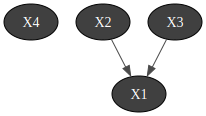

In [35]:


cbn = gum.fastBN("X1<-X2;X4;X1<-X3")
gnb.showBN(cbn)

### The Dataset

In [36]:
data = pd.read_csv( "data/bn_data.csv" , sep='\t')
data

,X1,X2,X3,X4
0,0.56,0.48,0.60,0.05
1,0.46,0.40,0.45,0.26
2,0.58,0.62,0.69,0.76
3,0.45,0.57,0.52,0.44
4,0.35,0.69,0.46,0.69
...,...,...,...,...
994,0.64,0.22,0.57,0.54
995,0.37,0.62,0.46,0.93
996,0.52,0.46,0.53,0.16
997,0.36,0.57,0.42,0.51


In [37]:
# drop columns X3 and X4 from data
# data = data.drop(['X4'], axis=1)

In [38]:
#data = add_noise( data, 0.2 )

In [79]:
def generate_data(n_samples: int = 1000):
    # Generate independent variables
    X4 = np.random.randn(n_samples)
    X2 = np.random.randn(n_samples)
    X3 = np.random.randn(n_samples)
    
    # Generate X1 as a linear combination of X2 and X3 plus some Gaussian noise
    beta2, beta3 = 0.8, 0.9  # Arbitrarily chosen coefficients
    noise = np.random.randn(n_samples) # Gaussian noise with standard deviation 0.2
    X1 = beta2 * X2 + beta3 * X3 + noise
    
    # Combine into a dataframe
    df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4})
    
    return df

# Generate a sample dataset
data = generate_data(n_samples = 100000)
data.head()


,X1,X2,X3,X4
0,-0.973886,-0.363218,-1.071218,-1.157639
1,0.218027,0.016879,-0.366619,-0.545788
2,-1.546256,-1.222335,0.752865,-0.280338
3,0.072627,-0.486885,0.009474,-0.478695
4,0.096534,1.891630,-0.586446,2.906933


## Structure MCMC

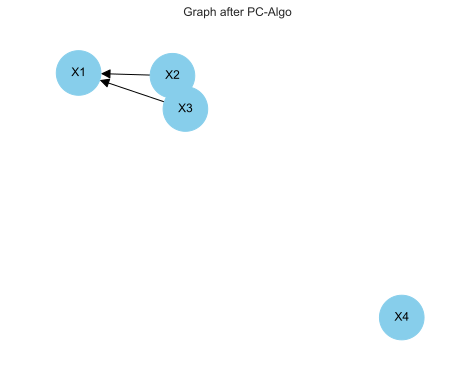

In [80]:
from src.StructureLearning import StructureLearningAlgorithm
from src.SGS import SGS

SGS_model = SGS()
SGS_model.fit(data)

initial_graph = SGS_model.get_structure()

plot_graph( initial_graph, title="Graph after PC-Algo" )

## Marginal Likelihood

In [81]:
NUM_ITERATIONS = 1000

# start with all nodes independet from each other
#initial_graph = nx.DiGraph()
#initial_graph.add_nodes_from(data.columns)

posteriors, graph_candidates, Gs, graphs, marginals, operations = structured_MCMC(data, initial_graph, NUM_ITERATIONS, score_function = "Marginal_Likelihood", restart_freq=100)

In [82]:
print(posteriors['acceptance_rate'])

0.554


In [83]:
print(np.mean(posteriors['mu']))

-291951.3273184815


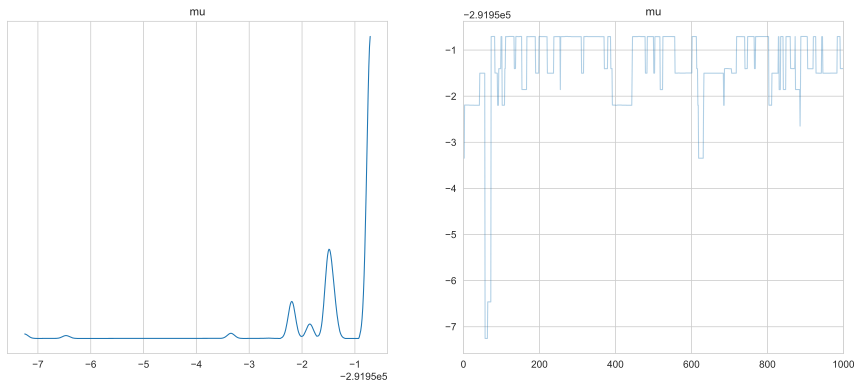

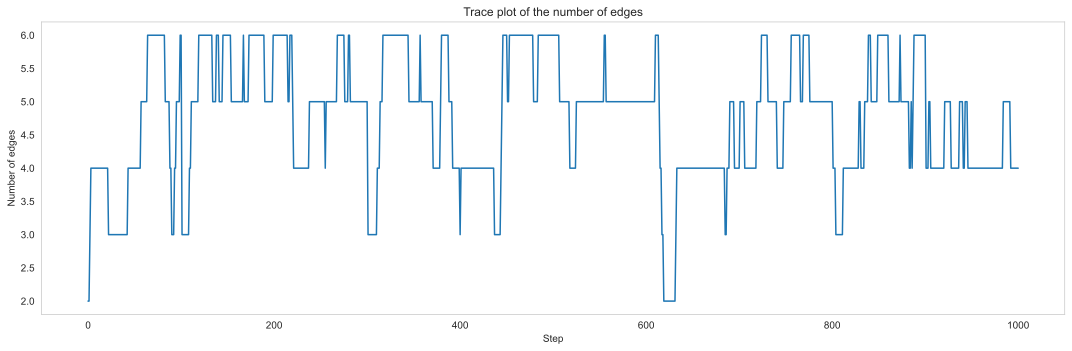

In [87]:
az.plot_trace(posteriors, var_names=["mu"], figsize=(15, 6));
plot_edges_trace( graph_candidates)

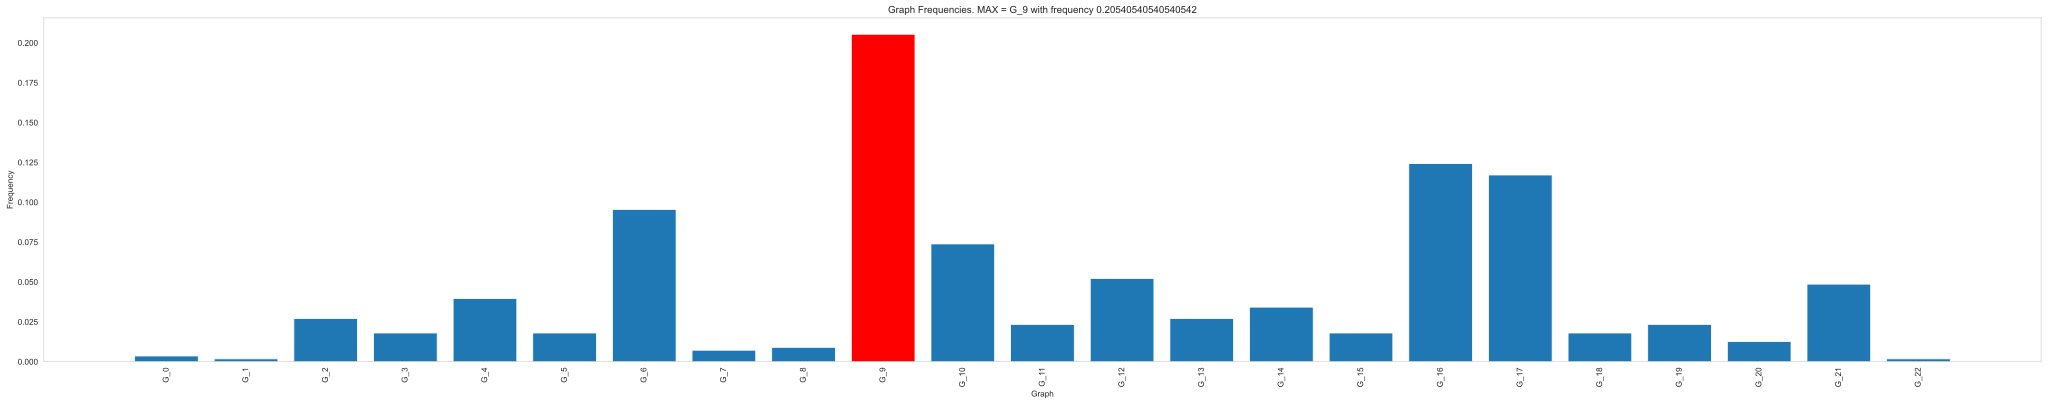

In [88]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs) )

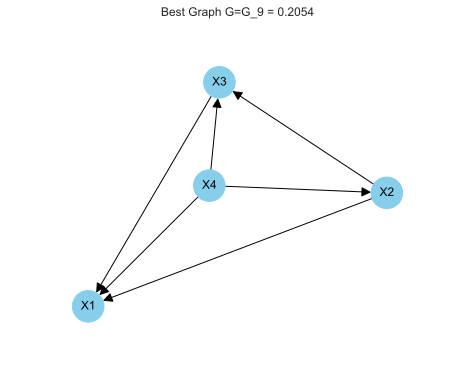

In [89]:
for label in max_labels:
    plot_graph( graphs[label], f"Best Graph G={label} = {np.round(max_freq,4)}", node_size = 1000)

## BGe

In [90]:

NUM_ITERATIONS = 1000

# start with all nodes independet from each other
#initial_graph = nx.DiGraph()
#initial_graph.add_nodes_from(data.columns)

posteriors_bge, graph_candidates_bge, Gs_bge, graphs_bge, marginals_bge, operations_bge = structured_MCMC(data, initial_graph, NUM_ITERATIONS, score_function = "BGe", restart_freq=100)

In [91]:
print(posteriors_bge['acceptance_rate'])

0.81


In [92]:
print(np.mean(posteriors_bge['mu']))

261764.31715464534


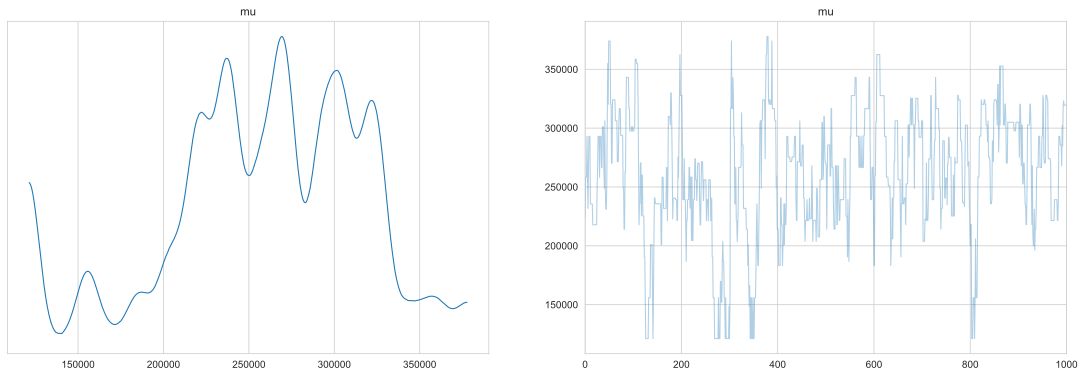

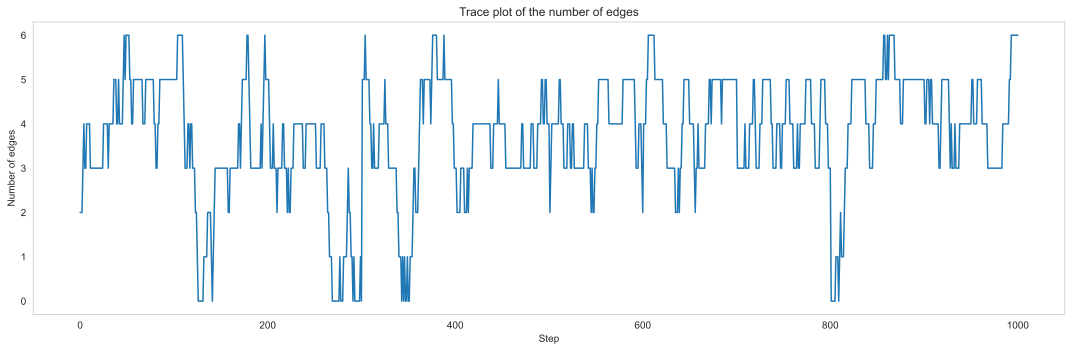

In [93]:
az.plot_trace(posteriors_bge, var_names=["mu"], figsize=(19, 6));
plot_edges_trace( graph_candidates_bge)

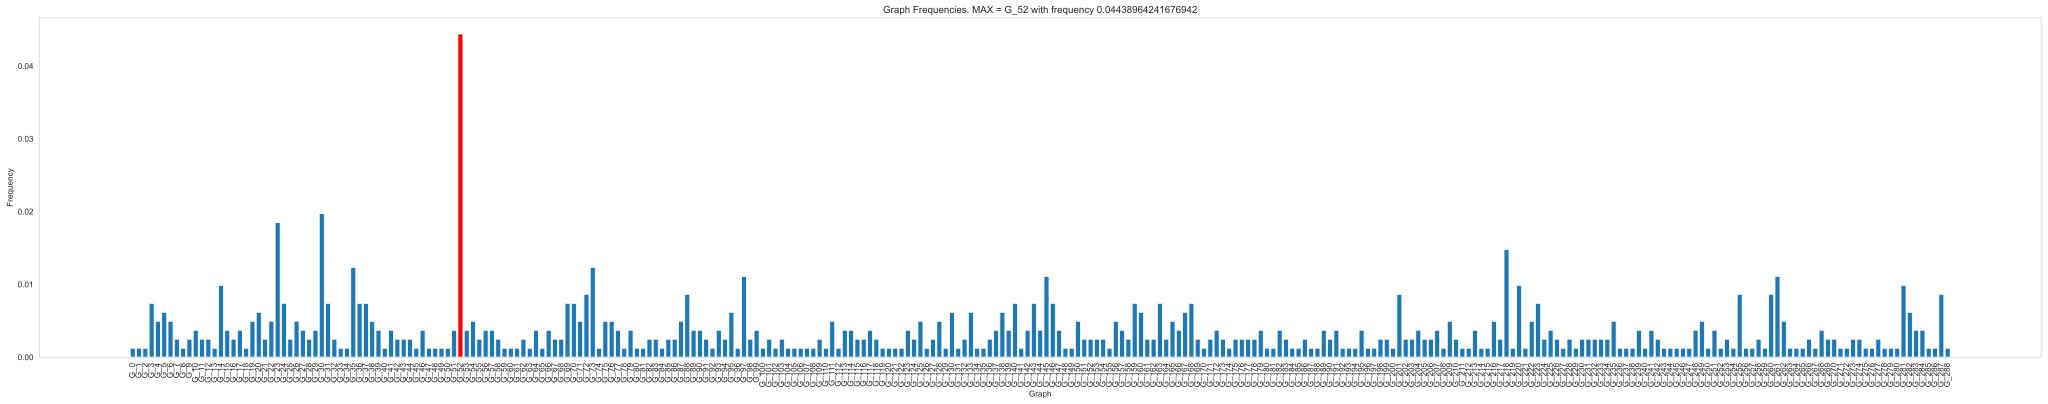

In [94]:
max_labels, max_freq = plot_graph_distribution( normalise_Gs(Gs_bge) )

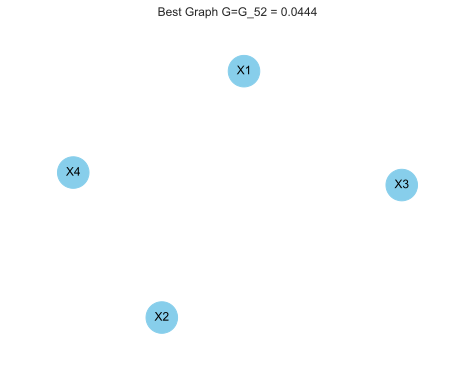

In [95]:
for label in max_labels:
    plot_graph( graphs_bge[label], f"Best Graph G={label} = {np.round(max_freq,4)}", node_size = 1000)